# Confusion matrix

## Import required Libraries:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import script.ImageProcessing as IP
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from concurrent.futures import ThreadPoolExecutor

In [2]:
# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Load Your Model and Data:
Load your trained model and the data you want to evaluate. Make sure you preprocess the data in the same way you did during training.

In [3]:
DIR = "D:\\Github Public\\DATASET MANAGER\\Blue Archive"
datapath_list = [os.path.join(root,image) for root, _, files in os.walk(DIR, topdown=True) for image in files]
datapath_list = [path for path in datapath_list if any(ext in path for ext in (".png", ".jpg"))]
datapath_list = [path for path in datapath_list if "TESTING" not in path]
datapath_list = [(path, path.split('\\')[-2]) for path in datapath_list]

In [4]:
imagepath_list = [path for path, _ in datapath_list]
label_list = [label for _, label in datapath_list]

class_list = sorted(list(set(label_list)))


In [5]:
H5_PATH = './export model/Res2Net50_224x224_2Class_fp16 (ILLUST VS MANGA).h5'
MODEL = load_model(H5_PATH)  # Load your trained Keras model
MODEL_NAME = H5_PATH.split('/')[-1].replace('.h5','')
IMAGE_SIZE = MODEL.layers[0].input_shape[0][1]
PROG_BAR = tf.keras.utils.Progbar(len(imagepath_list))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


## Generate Predictions:
Use your model to predict the classes for the input data.

In [6]:
def predict(image_path):
    image = IP.image_resize_square(image_path, IMAGE_SIZE, aspect_ratio=True, padding=True)
    image = np.expand_dims(image.numpy(), axis=0)
    PROG_BAR.add(1)
    #progress_bar.update(idx+1)
    return MODEL.predict(image)

In [7]:
max_threads = os.cpu_count()  # Maximum number of concurrent threads
with ThreadPoolExecutor(max_threads) as executor:
    predictions_list = list(executor.map(predict, imagepath_list))

# Concatenate the results
predicted_class = np.concatenate(predictions_list)
predicted_class = np.argmax(predicted_class, axis=1)
predicted_class = [class_list[idx] for idx in predicted_class]

4552/4552 [==============================] - 318s 70ms/step   ==================>.] - ETA: 0s2s - ETA: 12s===============>3920/4552 [======================3967/4552 [==4027/4552 [=4106/4552 [==========================>...] - ETA: 4111/4552 [==========================>...] - ETA: 34113/4552 [=====4246/4552 [=======================4505/4552 [==========4537/4552 [============================>.] -


## Calculate the Confusion Matrix:
Create the confusion matrix using the true labels and predicted labels.

In [8]:
# Assuming 'y_test' contains the true labels
confusion_mtx = confusion_matrix(label_list, predicted_class)


## Display the Confusion Matrix:
You can visualize the confusion matrix using a heatmap for better interpretation.

Confusion Matrix:
[[3927   10]
 [ 193  422]]


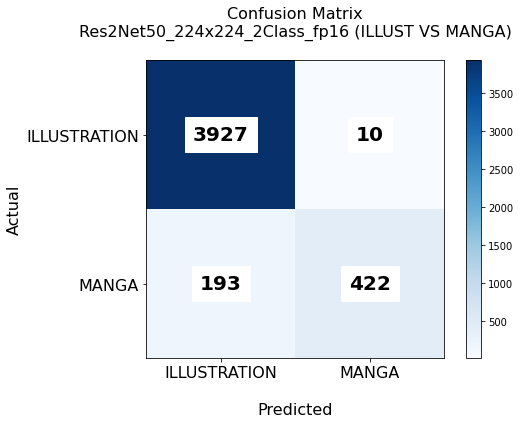

In [64]:
print("Confusion Matrix:")
print(confusion_mtx)

# Plotting the confusion matrix as a heatmap
fig = plt.figure(figsize=(8,6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix\n{MODEL_NAME}\n', fontsize=16)
plt.colorbar()

# Adding axis labels
plt.xticks(np.arange(len(class_list)), class_list, rotation=0, fontsize=16)
plt.yticks(np.arange(len(class_list)), class_list, fontsize=16)

# Adding annotations (numbers) in the cells
for i in range(len(class_list)):
    for j in range(len(class_list)):
        plt.text(j, i, str(confusion_mtx[i, j]), 
                 ha='center', 
                 va='center', 
                 backgroundcolor='white',
                 color='black',
                 fontsize=20,
                 fontweight=1000,
                 )

plt.xlabel('\nPredicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig(f'{MODEL_NAME}.jpg')